In [1]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from dask.distributed import Client, progress
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from scipy import stats
import scipy
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage import gaussian_filter

from modules.plotter import make_cmap
# %matplotlib inline

In [2]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(210,250))

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 0.17

xarray.Dataset {
dimensions:
	latitude = 81 ;
	longitude = 81 ;
	p = 37 ;
	time = 12 ;

variables:
	float64 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	float64 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	float32 p(p) ;
		p:lev_type = 100 ;
		p:units = mb ;
		p:long_name = p���L+ ;
	datetime64[ns] time(time) ;
		time:long_name = verification time generated by wgrib2 function verftime() ;
		time:reference_time_type = 1 ;
		time:reference_time_description = analyses, reference date is fixed ;
		time:time_step_setting = auto ;
		time:time_step = 0.0 ;
	float32 prmsl(time, latitude, longitude) ;
		prmsl:short_name = prmsl ;
		prmsl:long_name = Pressure ;
		prmsl:level = mean sea level ;
		prmsl:units = Pa ;
	float32 hgtprs(time, p, latitude, longitude) ;
		hgtprs:short_name = hgtprs ;
		hgtprs:long_name = Geopotential Height ;
		hgtprs:level = ��M ;
		hgtprs:units = m ;
	flo

In [3]:
da_SPFH = ds.spfh.sel(p=slice(1000,300))
da_V = ds.v.sel(p=slice(1000,300))
da_U = ds.u.sel(p=slice(1000,300))
pressure = ds.p.sel(p=slice(1000,300)).values

da_MSL = ds.prmsl
da_MSL = da_MSL/100 # convert to hPa

U_850 = ds.u.sel(p=850.0)* 1.94384 ## convert to knots
V_850 = ds.v.sel(p=850.0)* 1.94384 ## convert to knots

da_GPH = ds.hgtprs.sel(p=500.0)

da_CAPE = ds.capesfc

In [4]:
lats = ds['latitude']
lons = ds['longitude']

In [5]:
g = -9.81 # gravity constant
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=1)*g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=1)*g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

(9, 81, 81)
(9, 81, 81)


./figures/fS4.png


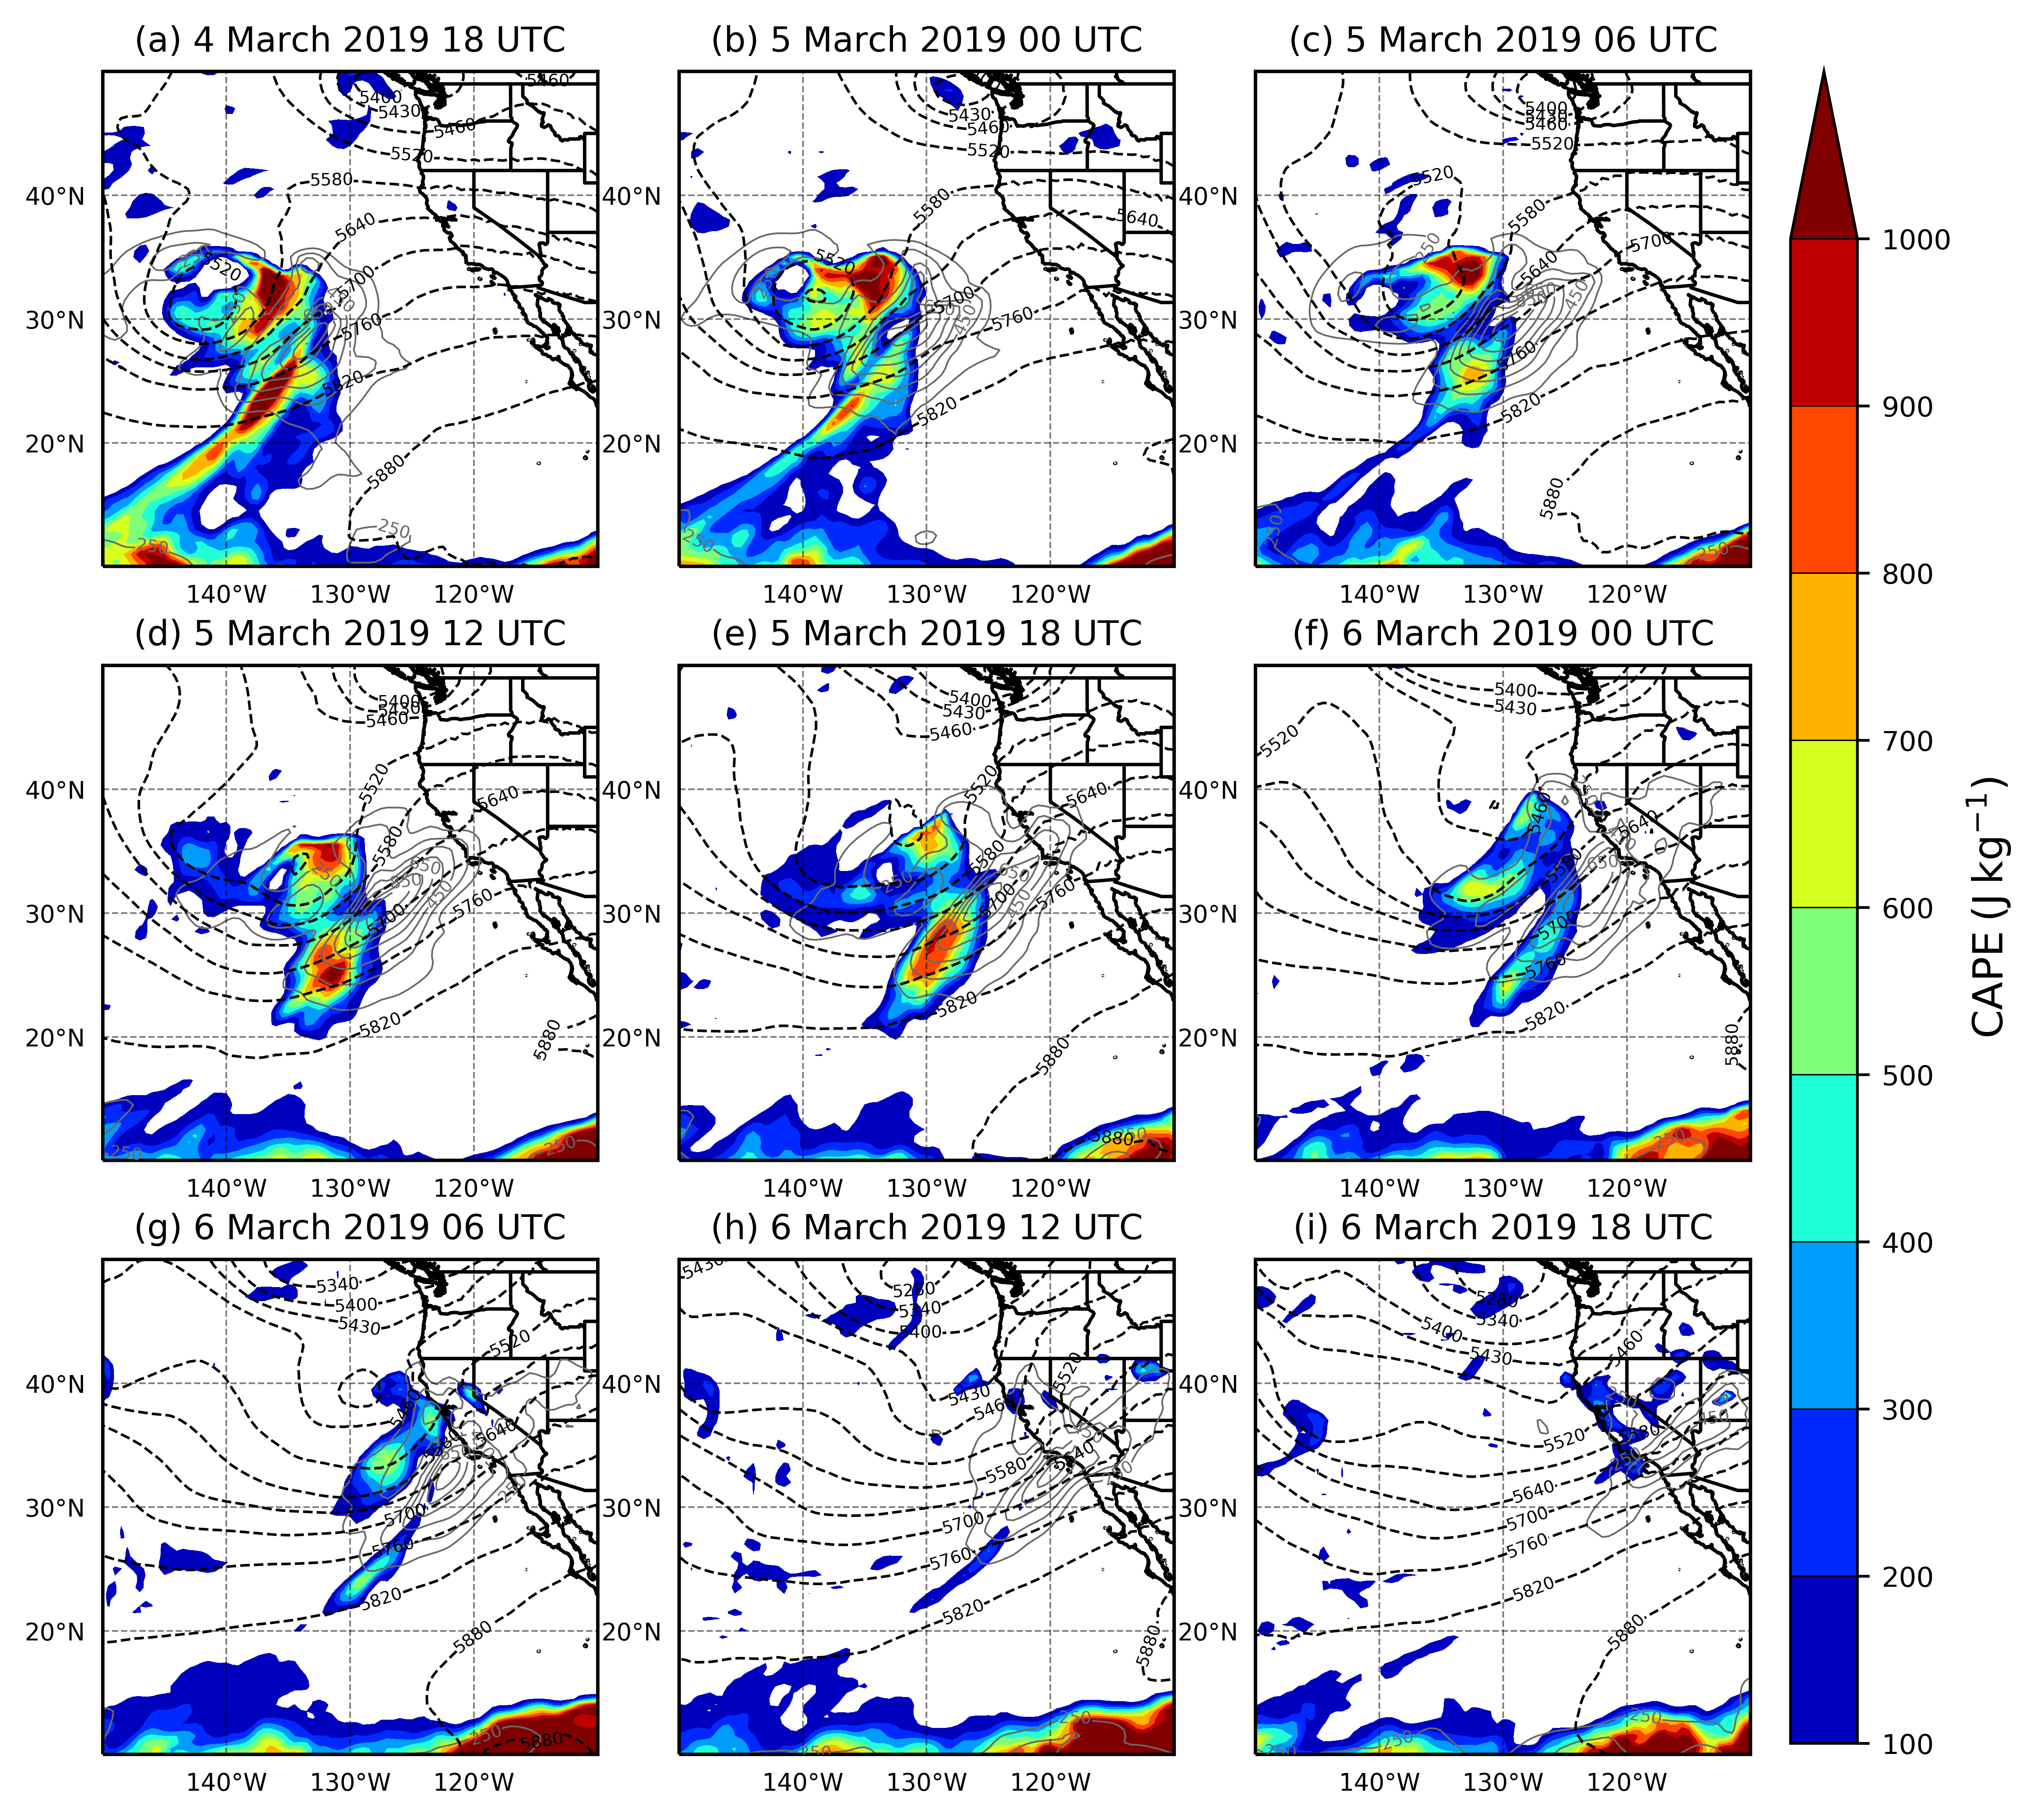

<Figure size 5400x5400 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(9,9))
fig.dpi = 600
fname = './figures/fS4'
fmt1 = 'png'
fmt2 = 'pdf'
results = da_CAPE
subtitles = ['(a) 4 March 2019 18 UTC', 
             '(b) 5 March 2019 00 UTC', '(c) 5 March 2019 06 UTC', '(d) 5 March 2019 12 UTC',
             '(e) 5 March 2019 18 UTC',
            '(f) 6 March 2019 00 UTC', '(g) 6 March 2019 06 UTC', '(h) 6 March 2019 12 UTC',
             '(i) 6 March 2019 18 UTC']

lats = ds['latitude']
lons = ds['longitude']
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    
    # Add Border Features
    ax.coastlines(linewidths=1.0, resolution='10m')
    ax.add_feature(states_provinces, edgecolor='k')
    ax.add_feature(cfeature.BORDERS)
    
    
    # Plot CAPE
    capeclevs = np.arange(100,1100,100)
    cf = ax.contourf(lons, lats, da_CAPE[i], transform=datacrs,
                     extend='max', cmap='jet', levels=capeclevs)
    
    # Plot IVT contours
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    ivtclevs = np.arange(250,1150,100)
    ivt_sm = gaussian_filter(ivt_total[i], sigma=0.75)
    cs = ax.contour(lons, lats, ivt_sm, ivtclevs, colors='dimgrey', linewidths=0.5,
                      linestyles='solid', transform=datacrs)
    plt.clabel(cs, cs.levels[::2], **kw_clabels)

    # Plot GPH with multiple colors
    clevsgph = (np.arange(0, 5430, 60),
         np.array([5430]),
         np.arange(5460, 7000, 60))
    colors = ('tab:blue', 'b', 'tab:red')
    for clevthick, color in zip(clevsgph, colors):
        cs = ax.contour(lons, lats, da_GPH[i,:,:], levels=clevthick, colors='k',
                        linewidths=0.75, linestyles='dashed', transform=datacrs)
        plt.clabel(cs, **kw_clabels)
    
    
    ax.set_title(subtitles[i], fontsize=10)
    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-150, -140, -130, -120, -110])
    gl.ylocator = mticker.FixedLocator([10,20, 30, 40, 50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label(r'$\mathrm{CAPE \:(J\:kg^{-1})}$', fontsize=12)

plt.subplots_adjust(hspace=0.2, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))